### 0001137778 Davide Cremonini davide.cremonini8@studio.unibo.it
### 0001146107 Gabriele Nanni gabriele.nanni4@studio.unibo.it

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 25.68 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import random
import numpy as np
from torchvision.transforms import v2
from collections import OrderedDict
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=1)

In [ ]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

<h2>Preparation of the environment</h2>
We start importing some useful libraries and setting the device. The seeds will be set again at the beginning of the training to ensure that every training is repeatable, even running only the training part multiple times.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cuda


<h2>Data Augmentation</h2>
We define the transformations to apply to the data to have a more generalized model.<br>
The 'transform' pipeline is the one used for the training set, having in this way more variety and avoiding excessive overfitting, the 'no_transform' pipeline was used to train the network to compare the results and lastly the 'val_transform' is the pipeline used for the validation set. As it is possible to observe, the pipeline used on the training set combines more random and complex transformations with respect to the 'val_transform'.
As we decided to implement random resized cropping for the training data we decided to resize the validation data by upscaling them as a way to counter the difference in resolution between the two sets.

In [ ]:
# Define any transformations you want to apply to the images

no_transform = transforms.Compose([
    transforms.CenterCrop(224),
     transforms.ToTensor(), # Convert images to PyTorch tensors
 ])

transform = transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(int(1.25 * 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Create an instance of the dataset
dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=val_transform)

# Exploring the Dataset

Here we observe the distribution of the dataset. It is cleary noticable that there is an imbalance between the classes. This problem will be tackled with hyperparameters set and discussed later on in the notebook.

In [ ]:
print(f"There are {len(dataset)} training images")
print(f"There are {len(val_dataset)} validation images")

There are 2640 training images
There are 296 validation images


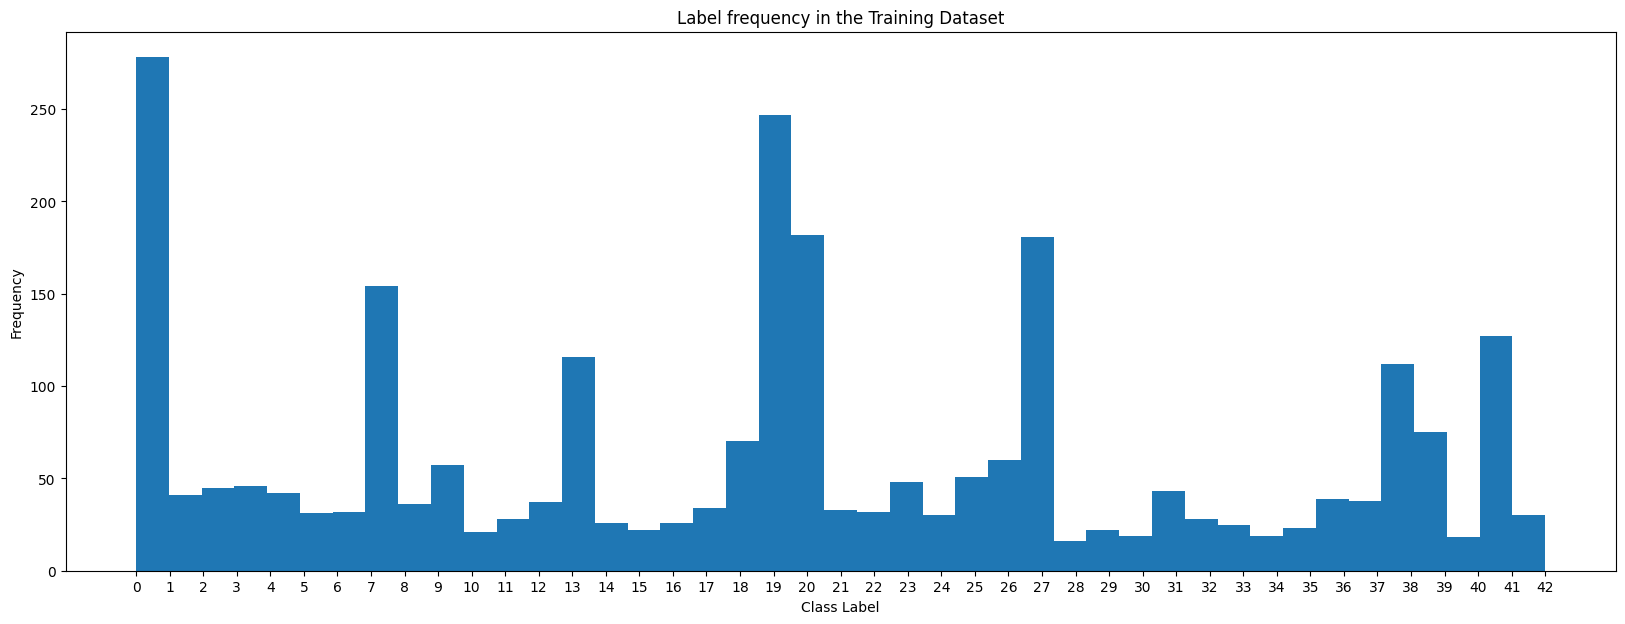

In [ ]:
plt.figure(figsize=(20,7))
plt.title("Label frequency in the Training Dataset")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.xticks(range(0,dataset.get_num_classes()))
hist=plt.hist(dataset.labels, bins=dataset.get_num_classes())

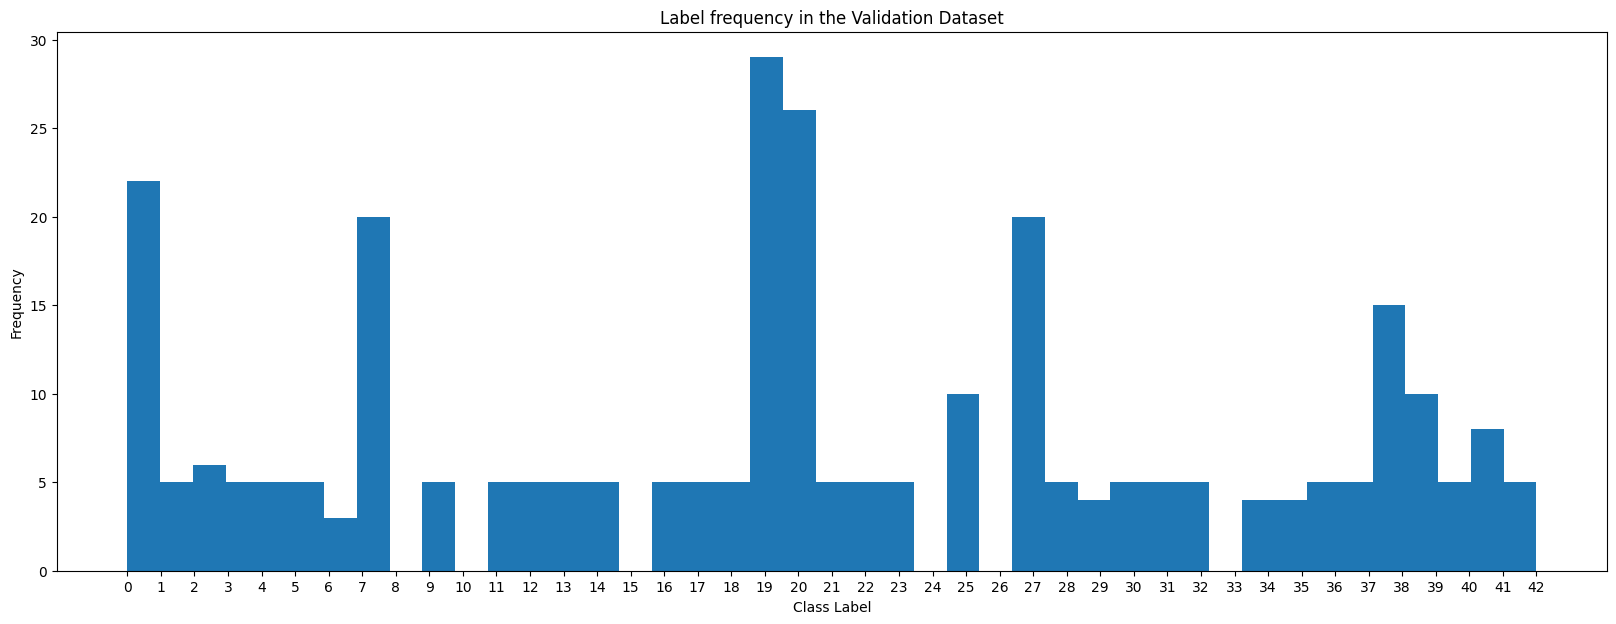

In [ ]:
plt.figure(figsize=(20,7))
plt.title("Label frequency in the Validation Dataset")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.xticks(range(0,dataset.get_num_classes()))
hist=plt.hist(val_dataset.labels, bins=val_dataset.get_num_classes())

<h2>Model structure</h2>
The idea of this experiment was to build a simple, modular network, following the concepts described in VGG. For this reason we relied on pretty simple blocks constituted by a convolutional layer, a normalization layer (to regularize and avoid gradient explosion) and a LeakyReLU activation.<br>
The entire structure is in fact a chain of blocks, among which had been added pooling layers (both MaxPooling and AvgPooling layers have been tested, the results weren't significantly different with a slight preference for the MaxPool)
The main idea was to experiment with different numbers of blocks to find the best network possible utilizing these simple blocks.

### Basic Block Definition

In [ ]:
#Define model of a block
class ConvBnRelu(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBnRelu, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu1 = torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        return x

### *reduce_size*

In [ ]:
def reduce_size(in_size, k_size, stride, pad):
        return ((in_size - k_size+2*pad)//stride)+1

### Modular Network Definition

In order to make model definition easier we developed an extension of the Module class that could modularly build a parametrical neural network described as before by concatenating a sequence of block, intertwined by pooling layers, the result is the *ModularConvNet* class.
This class helps instantiate a network made of convolutional blocks which act as a feature extractor and e classifier build using fully connected layers, each block has a channel size which is double than the previous one, with the first convolutional layer performing the doubling.
* The *in_channels* parameter specifies the the number of channels defined of the input which will be converted to the base of the network by the first block.
* The *out_classes* parameter defines the number of logits that the classifier has to produce it output.
* The *conv_layers* parameter, which is a list of dictionaries describing the characteristic number of units in the block, kernel size, stride and padding for each layer inside it; it is used to instantiate each block by concatenating **ConvBnRelu** units, each disctionary is used for one block. As discussed before, the first element of the block doubles the number of channels, while the following ones maintain that number of channels througout it.
* The *channel_base* parameter allows to specify the size for the first block, which will be doubled later.
* The *fc_layers* parameter specifies the number of activations present inside the fully connected layes through an array of integers.
* The *pool* specifies the type of pooling used by the network. The network is designed to perform only one type of pooling which can be selected by setting the pool parameter to "Avg" or "Max" for the desired type. All pooling will be applied with kernel size 2 and stride 2 to avoid excessive downsampling.
* The boolean parameter *pool_after_block* is used to specify if the pooling operation has to be performed after every block (True) or after each ConvBnRelu unit (False)
* The *drop* parameter specifies if dropout layers have to be inserted between fully connected ones.

Inside the class convolutional and fully connected layers end up constituing two attributes as sequences of modules, which helps simplifying the definition of the forward function.
As the network is designed to interact with the **CrossEntropyLoss** defined by PyTorch, which expects raw logits in input (as it will compute softmax inside), the network does not use a softmax function for the output.

In [ ]:
class ModularConvNet(torch.nn.Module):



    def __init__(self, in_size=224, in_channels=3, out_classes=43, conv_layers=None, channel_base=32, fc_layers=None, pool="Avg", pool_after_block=True, drop=False):
        super(ModularConvNet, self).__init__()
        #The image is assumed to have equal size and width equal to in_size
        #conv_layers is a list of dictionaries formatted as: {"Num":number of layers in the block,
                                                          #"Size":kernel size for each layer in the block
                                                          #"Stride":stride for each layer in the block
                                                          #"Pad":padding for each layer in the block}
                    #Each dictionary descibes how to realize a block containing Num ConvBnRelu modules with kernel size Size, stride Stride and padding Pad.

        self.activation_size = in_size

        conv_dict=OrderedDict()
        channel_factor = 1
        for i in range(len(conv_layers)):
            block = conv_layers[i]
            for n in range(block["Num"]):
                if i == 0 and n ==0:
                    conv_dict.update({f"ConvBnRelu_{i+1}_{n+1}":ConvBnRelu(in_channels=in_channels,
                                                    out_channels=channel_base*channel_factor,
                                                    kernel_size=block["Size"],
                                                    stride=block["Stride"],
                                                    padding=block["Pad"])})
                    self.activation_size = reduce_size(self.activation_size, block["Size"], block["Stride"], block["Pad"] )
                elif i>0 and n==0:
                    conv_dict.update({f"ConvBnRelu_{i+1}_{n+1}":ConvBnRelu(in_channels=channel_base*(channel_factor//2),
                                                    out_channels=channel_base*channel_factor,
                                                    kernel_size=block["Size"],
                                                    stride=block["Stride"],
                                                    padding=block["Pad"])})
                    self.activation_size = reduce_size(self.activation_size, block["Size"], block["Stride"], block["Pad"] )
                else:
                    conv_dict.update({f"ConvBnRelu_{i+1}_{n+1}":ConvBnRelu(in_channels=channel_base*channel_factor,
                                                    out_channels=channel_base*channel_factor,
                                                    kernel_size=block["Size"],
                                                    stride=block["Stride"],
                                                    padding=block["Pad"])})
                    self.activation_size = reduce_size(self.activation_size, block["Size"], block["Stride"], block["Pad"] )


                if not pool_after_block and pool == "Avg":
                    conv_dict.update({f"Avg_{i+1}_{n+1}":torch.nn.AvgPool2d(kernel_size=2, stride=2)})
                    self.activation_size = reduce_size(self.activation_size, 2, 2, 0 )
                elif not pool_after_block and pool == "Max":
                    conv_dict.update({f"Max_{i+1}_{n+1}":torch.nn.MaxPool2d(kernel_size=2, stride=2)})
                    self.activation_size = reduce_size(self.activation_size, 2, 2, 0 )



            if pool_after_block and pool == "Avg":
                conv_dict.update({f"Avg_{i+1}":torch.nn.AvgPool2d(kernel_size=2, stride=2)})
                self.activation_size = reduce_size(self.activation_size, 2, 2, 0 )
            elif pool_after_block and pool == "Max":
                conv_dict.update({f"Max_{i+1}":torch.nn.MaxPool2d(kernel_size=2, stride=2)})
                self.activation_size = reduce_size(self.activation_size, 2, 2, 0 )

            channel_factor*=2

        self.conv_layers = torch.nn.Sequential(conv_dict)

        self.fc_in_size = (channel_base*(channel_factor//2)*self.activation_size*self.activation_size)

        fc_dict = OrderedDict()

        fc_dict.update({f"Fc_1":torch.nn.Linear(self.fc_in_size, fc_layers[0])})

        fc_dict.update({f"Relu_1":torch.nn.LeakyReLU()})

        if drop:
                fc_dict.update({f"Dropout_1":torch.nn.Dropout(p=0.5)})

        for f in range(len(fc_layers)-1):
            fc_dict.update({f"Fc_{2+f}":torch.nn.Linear(fc_layers[f],fc_layers[f+1])})
            fc_dict.update({f"Relu_{2+f}":torch.nn.LeakyReLU()})
            if drop:
                fc_dict.update({f"Dropout_{2+f}":torch.nn.Dropout(p=0.5)})

        fc_dict.update({f"Fc_Last":torch.nn.Linear(fc_layers[len(fc_layers)-1], out_classes)})


        if drop:
                fc_dict.update({f"Dropout_Last":torch.nn.Dropout(p=0.5)})


        self.fc_layers = torch.nn.Sequential(fc_dict)




    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.fc_in_size)
        x = self.fc_layers(x)
        return x


# Training Models

## Setting Hyperparameters

We define the hyperparameters that will be used in the training part. They were subject of tuning but since the other results weren't at all satisfactory (most of the trials didn't even reach 50% accuracy on the validation set) they aren't shown here.

* The shuffling, weight_decay and label smoothing parameters are introduced to reduce overfitting and obtain a regularization effect. That's because (even if it is still evident in all the models) overfitting was a significant issue tackling this problem.
* Also the batch_size has been set at 64 because this was the right middle ground to obtain a less noisy gradient and an affordable computational cost. Experiments were made with batch_size=32 and batch_size=128, but the first led to higher oscillation in the loss function and the second led to very long computation time.
* Despite being the default values, experimenting with different gamma and learning rate values, we observed that the results were not as satisfactory as the one chosen, in fact the loss function got stuck much earlier in case of higher learning rate and didn't progress much in case of smaller ones.

In [ ]:
num_epochs = 40 # @param {"type":"integer"}
batch_size = 64 # @param {"type":"integer"}
shuffle = True # @param {"type":"boolean"}
learning_rate = 0.001 # @param {"type":"number"}
weight_decay = 0.01 # @param {"type":"number"}
label_smoothing=0.01 # @param {"type":"number"}
gamma=0.9 # @param {"type":"number"}

## Utility functions

We now define some utility functions used throughout the notebook to perform trianing loop, validation and visualization of the results.

### Validation function

In [ ]:
def validate(val_loader, model):
  model.eval()
  with torch.no_grad():
        correct = 0
        total = 0
        running_val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            current_val_loss = criterion(outputs, labels)
            running_val_loss += current_val_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        return avg_val_loss, 100 * correct / total

### Training loop function

In [ ]:
#Training function

def train_loop(trainloader, valloader, model, loss_fn, optimizer, scheduler):
    losses = []
    accuracies = []
    val_accuracies = []
    val_losses = []
    best_accuracy = 0
    best_loss = 0
    best_epoch = 0

    # We use the pre-defined number of epochs to determine how many iterations to train the network on
    for epoch in range(num_epochs):
        running_loss = 0
        correct_predictions = 0
        total_predictions = 0
    # Load in the data in batches using the train_loader object
        model.train()  # Set the model to training mode
        for i, (images, labels) in enumerate(trainloader):

            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            #Clearing old gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        # Calculate average loss and accuracy for the epoch
        avg_loss = running_loss / len(trainloader)
        accuracy = correct_predictions / total_predictions * 100  # Accuracy as a percentage

        # Store epoch results
        losses.append(avg_loss)
        accuracies.append(accuracy)

        val_loss, val_acc = validate(valloader, model)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        scheduler.step()

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_loss = val_loss
            best_epoch = epoch
            torch.save(model, 'best-model.pt')
            torch.save(model.state_dict(), 'best-model-parameters.pt')
        if epoch % 4 == 3:
            print('Epoch [{}/{}]\n Loss: {:.4f}, Accuracy: {:.4f}\n Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch+1, num_epochs, avg_loss, accuracy, val_loss, val_acc))

    return losses, accuracies, val_losses, val_accuracies, best_accuracy, best_loss, best_epoch

### Plotting graphs

In [ ]:
def plot_stats(num_epochs, losses, val_losses, accuracies, val_accuracies):
  epochs = range(1, num_epochs + 1)

  null=plt.figure(figsize=(12, 5))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, losses, label='Training Loss')
  plt.plot(epochs, val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Over Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracies, label='Training Accuracy')
  plt.plot(epochs, val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.title('Accuracy Over Epochs')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# Create DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)

Even if the dataset was extremely unbalanced and was reasonable to think that weighting the errors based on the number of instances for each class the results were found worse than the ones obtained without balancing the classes.

In [ ]:
# Set Loss function with criterion
criterion = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)

### Model 1 - Definition

The first noticable model presents four basic blocks, each one formed by one single unit. this sctructure was the first one to fit in a rather precise way the training set (~90% accuracy), but getting only ~50% accuracy on the validation set.
Probably has enough complexity to capture most of the features of the training dataset, but not enough to actually generalize and correctly classify unseen data. This generalization issue could be caused by the great number of features captured by the fc layers. (512 pabameters is the highest of the settings of the networks)

In [ ]:
#Model 1
num_classes = dataset.get_num_classes()
model=ModularConvNet( in_size= 224,
                     in_channels=3,
                     out_classes=num_classes,
                     conv_layers=[{"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":1,"Size":3,"Stride":1,"Pad":0},],
                     channel_base=32,
                     fc_layers=[512],
                     pool="Max",
                     pool_after_block=False,
                     drop=False)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
model=model.to(device)
print(model)

Number of parameters: 19286315
ModularConvNet(
  (conv_layers): Sequential(
    (ConvBnRelu_1_1): ConvBnRelu(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
    )
    (Max_1_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ConvBnRelu_2_1): ConvBnRelu(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
    )
    (Max_2_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ConvBnRelu_3_1): ConvBnRelu(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
    )
    (Max_3_

### Model 1 - Training

Our choice was to utilize AdamW optimizer paired with an exponential decay scheduler for the learning rate. Other attempts were made with the SGD and Adam optimizers and other schedulers like StepLR and OneCycleLR but none of them led to significant results. This observation can be applied to every model shown.

In [ ]:
# Set optimizer with optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

Epoch [4/40]
 Loss: 1.9827, Accuracy: 38.9394
 Validation Loss: 2.4005, Validation Accuracy: 27.0270
Epoch [8/40]
 Loss: 1.3356, Accuracy: 59.8106
 Validation Loss: 2.1394, Validation Accuracy: 34.1216
Epoch [12/40]
 Loss: 1.0304, Accuracy: 68.6742
 Validation Loss: 2.0972, Validation Accuracy: 38.5135
Epoch [16/40]
 Loss: 0.8519, Accuracy: 75.2652
 Validation Loss: 1.9566, Validation Accuracy: 45.2703
Epoch [20/40]
 Loss: 0.7278, Accuracy: 80.1894
 Validation Loss: 1.9789, Validation Accuracy: 43.5811
Epoch [24/40]
 Loss: 0.6325, Accuracy: 84.6970
 Validation Loss: 2.0055, Validation Accuracy: 48.3108
Epoch [28/40]
 Loss: 0.5591, Accuracy: 86.3258
 Validation Loss: 1.8987, Validation Accuracy: 46.2838
Epoch [32/40]
 Loss: 0.5452, Accuracy: 86.9318
 Validation Loss: 2.0027, Validation Accuracy: 45.6081
Epoch [36/40]
 Loss: 0.5252, Accuracy: 88.4470
 Validation Loss: 1.9272, Validation Accuracy: 48.6486
Epoch [40/40]
 Loss: 0.4799, Accuracy: 90.2273
 Validation Loss: 1.8570, Validation 

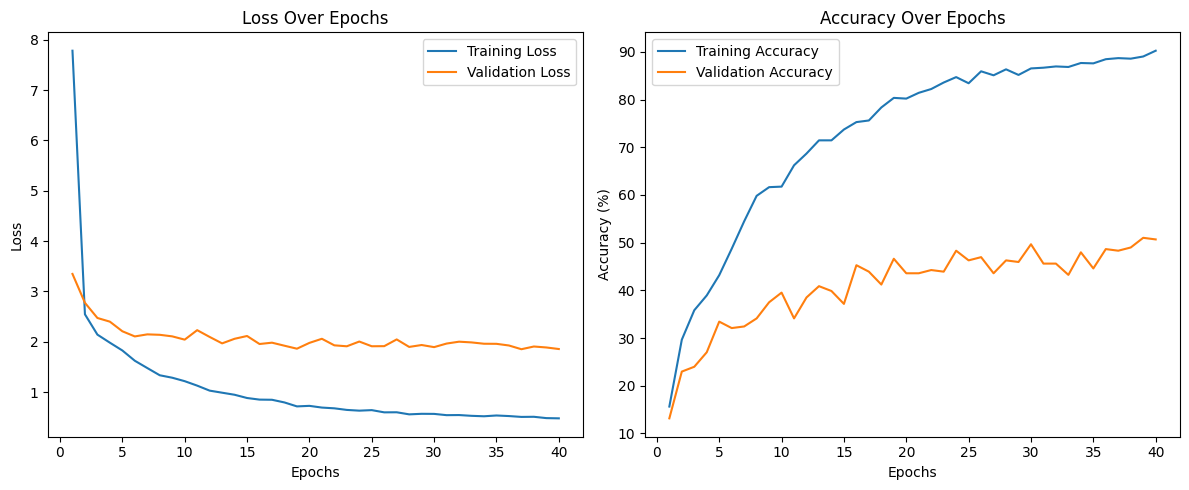

Best accuracy epoch 39
	Validation Loss: 1.8878783464431763, Validation Accuracy: 51.013513513513516


In [ ]:
losses, accuracies, val_losses, val_accuracies, best_accuracy, best_loss, best_epoch = train_loop(train_loader, val_loader, model, criterion, optimizer, scheduler)
plot_stats(num_epochs, losses, val_losses, accuracies, val_accuracies)
print(f"Best accuracy epoch {best_epoch+1}\n\tValidation Loss: {best_loss}, Validation Accuracy: {best_accuracy}")

### Model 2 - Definition

In the second model we decided to trade off complexity in the fc layers with a deeper convolutional structure to capture more complex features in the images but in a smaller number to avoid extremely specific features that cause overfitting on the training set. This trade off caused an improvement in the validation accuracy, increasing it by almost 5%, proving this insight to be correct and the trend to be positive. In this specific case the use of average pooling has shown to be slightly more effective, reaching a validation accuracy of ~55%.

In [ ]:
#Model 2
num_classes = dataset.get_num_classes()
model=ModularConvNet( in_size= 224,
                     in_channels=3,
                     out_classes=num_classes,
                     conv_layers=[{"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  ],
                     channel_base=32,
                     fc_layers=[256],
                     pool="Avg",
                     pool_after_block=True,
                     drop=False)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
model=model.to(device)
print(model)

Number of parameters: 4858667
ModularConvNet(
  (conv_layers): Sequential(
    (ConvBnRelu_1_1): ConvBnRelu(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
    )
    (Avg_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (ConvBnRelu_2_1): ConvBnRelu(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
    )
    (Avg_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (ConvBnRelu_3_1): ConvBnRelu(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
    )
    (Avg_3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (ConvBnRelu

### Model 2 - Training

In [ ]:
# Set optimizer with optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

Epoch [4/40]
 Loss: 1.3722, Accuracy: 56.1364
 Validation Loss: 2.2195, Validation Accuracy: 33.4459
Epoch [8/40]
 Loss: 0.8892, Accuracy: 74.0530
 Validation Loss: 2.3472, Validation Accuracy: 39.8649
Epoch [12/40]
 Loss: 0.6968, Accuracy: 80.3788
 Validation Loss: 2.2435, Validation Accuracy: 39.8649
Epoch [16/40]
 Loss: 0.5414, Accuracy: 85.9848
 Validation Loss: 2.2742, Validation Accuracy: 41.8919
Epoch [20/40]
 Loss: 0.4585, Accuracy: 89.5455
 Validation Loss: 2.0735, Validation Accuracy: 44.5946
Epoch [24/40]
 Loss: 0.4346, Accuracy: 90.8712
 Validation Loss: 1.9879, Validation Accuracy: 46.9595
Epoch [28/40]
 Loss: 0.4057, Accuracy: 91.7045
 Validation Loss: 1.9358, Validation Accuracy: 51.6892
Epoch [32/40]
 Loss: 0.3595, Accuracy: 93.6364
 Validation Loss: 1.7985, Validation Accuracy: 54.0541
Epoch [36/40]
 Loss: 0.3639, Accuracy: 94.2803
 Validation Loss: 1.9758, Validation Accuracy: 51.0135
Epoch [40/40]
 Loss: 0.3479, Accuracy: 94.0530
 Validation Loss: 1.9271, Validation 

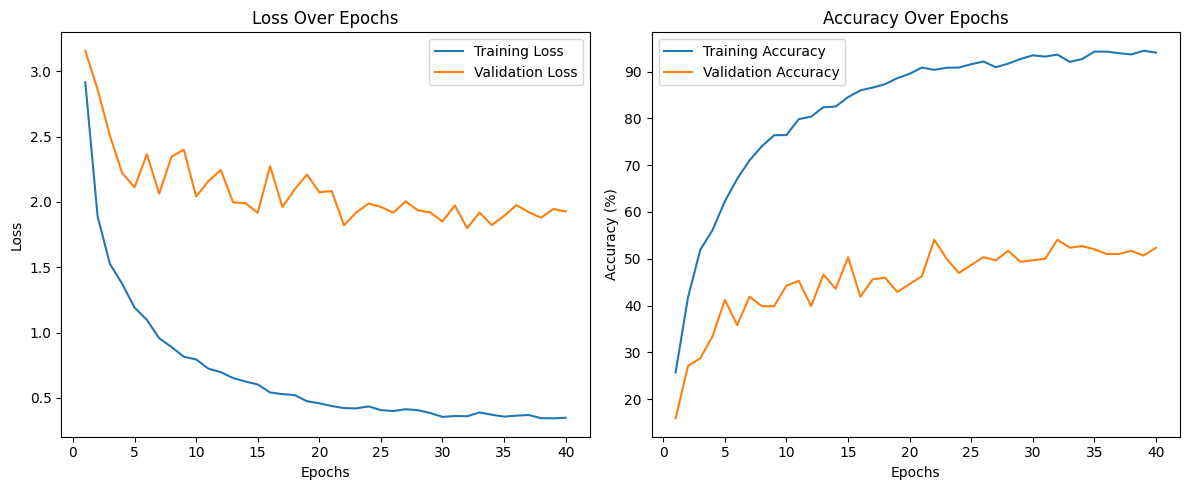

Best accuracy epoch 22
	Validation Loss: 1.8206602096557618, Validation Accuracy: 54.054054054054056


In [ ]:
losses, accuracies, val_losses, val_accuracies, best_accuracy, best_loss, best_epoch = train_loop(train_loader, val_loader, model, criterion, optimizer, scheduler)
plot_stats(num_epochs, losses, val_losses, accuracies, val_accuracies)
print(f"Best accuracy epoch {best_epoch+1}\n\tValidation Loss: {best_loss}, Validation Accuracy: {best_accuracy}")

### Model 3 - Definition

The final model shown was designed taking in consideration the positive trend observed before. The number of parameters of the fc layer was halved again and another convolutional layer was added, this time without doubling the channel size in the last layer. In the end, this model performed as requested reaching consistently a ~62% validation accuracy with peaks of 65% due to favorable random seeds. From this model we can observe the effectiveness of convolutional layers, in fact it is the model with the less parameters and it is the one reaching the best validation accuracy value.

In [ ]:
#Model 3
num_classes = dataset.get_num_classes()
model=ModularConvNet( in_size= 224,
                     in_channels=3,
                     out_classes=num_classes,
                     conv_layers=[{"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":1,"Size":3,"Stride":1,"Pad":0},
                                  {"Num":2,"Size":3,"Stride":1,"Pad":0},
                                  ],
                     channel_base=32,
                     fc_layers=[128],
                     pool="Max",
                     pool_after_block=False,
                     drop=False)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
model=model.to(device)
print(model)

Number of parameters: 4002603
ModularConvNet(
  (conv_layers): Sequential(
    (ConvBnRelu_1_1): ConvBnRelu(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
    )
    (Max_1_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ConvBnRelu_2_1): ConvBnRelu(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
    )
    (Max_2_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ConvBnRelu_3_1): ConvBnRelu(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
    )
    (Max_3_1

### Model 3 - Training

In [ ]:
# Set optimizer with optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

Epoch [4/40]
 Loss: 1.2357, Accuracy: 61.3636
 Validation Loss: 2.1153, Validation Accuracy: 39.5270
Epoch [8/40]
 Loss: 0.7759, Accuracy: 77.3485
 Validation Loss: 1.5937, Validation Accuracy: 54.0541
Epoch [12/40]
 Loss: 0.5312, Accuracy: 86.8561
 Validation Loss: 1.4990, Validation Accuracy: 59.1216
Epoch [16/40]
 Loss: 0.4222, Accuracy: 90.9848
 Validation Loss: 1.4903, Validation Accuracy: 57.0946
Epoch [20/40]
 Loss: 0.3610, Accuracy: 94.1288
 Validation Loss: 1.6762, Validation Accuracy: 54.3919
Epoch [24/40]
 Loss: 0.2843, Accuracy: 96.0606
 Validation Loss: 1.4615, Validation Accuracy: 59.4595
Epoch [28/40]
 Loss: 0.2662, Accuracy: 96.8561
 Validation Loss: 1.5261, Validation Accuracy: 58.7838
Epoch [32/40]
 Loss: 0.2544, Accuracy: 97.3106
 Validation Loss: 1.5660, Validation Accuracy: 60.8108
Epoch [36/40]
 Loss: 0.2488, Accuracy: 97.0076
 Validation Loss: 1.5083, Validation Accuracy: 61.1486
Epoch [40/40]
 Loss: 0.2442, Accuracy: 97.6515
 Validation Loss: 1.4962, Validation 

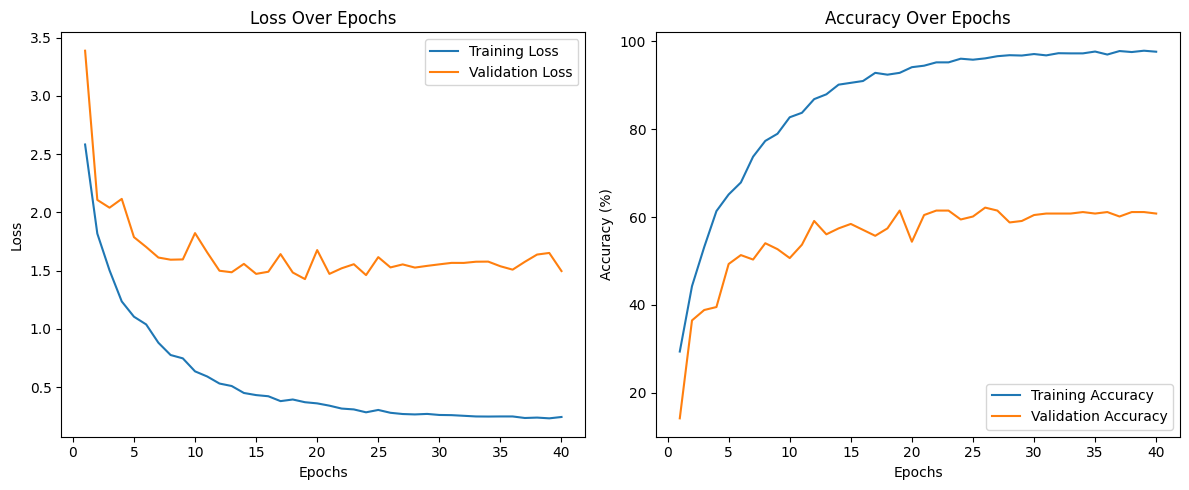

Best accuracy epoch 26
	Validation Loss: 1.5274724960327148, Validation Accuracy: 62.16216216216216


In [ ]:
losses, accuracies, val_losses, val_accuracies, best_accuracy, best_loss, best_epoch = train_loop(train_loader, val_loader, model, criterion, optimizer, scheduler)
plot_stats(num_epochs, losses, val_losses, accuracies, val_accuracies)
print(f"Best accuracy epoch {best_epoch+1}\n\tValidation Loss: {best_loss}, Validation Accuracy: {best_accuracy}")

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#creating dataset for resnet
resnet_dataset = GroceryStoreDataset(split='train', transform = data_transforms['train'])
resnet_val_dataset = GroceryStoreDataset(split='val', transform = data_transforms['val'])

#Creating data loader for resnet
resnet_train_loader = DataLoader(resnet_dataset, batch_size=batch_size, shuffle=shuffle)
resnet_val_loader = DataLoader(resnet_val_dataset, batch_size=batch_size, shuffle=shuffle)

## Simple fine-tuning

After having created the necessary transformation we wanted to try some different approaches for the tuning of the network:
<ul>
    <li>Simple fine-tuning leaving the model completely free to learn from the data</li>
    <li>Transfer Learning freezing the feature extractor weights for the first epochs</li>
    <li>Fine-tuning tweaking the previous hyperparameters to have better performance</li>
</ul>

We proceed creating a model with pretrained weights and changing only the classifier.<br>As we know the ResNet18 architecture has only one fully connected layer for classification, we decided to change that only creating a layer with the correct output features.

### Model Definition

In [ ]:
# Create the model with pretrained weights
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Extract the input features of the classifier
num_ftrs = model_ft.fc.in_features

# Change the classifier
model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)

# Move the model to GPU
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


We re-initialized the optimizer and the scheduler, the initialization of the loss function is only for clarity purpose.

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=learning_rate, weight_decay = weight_decay)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, gamma=gamma)

Epoch [4/40]
 Loss: 0.4003, Accuracy: 91.4015
 Validation Loss: 1.0188, Validation Accuracy: 72.2973
Epoch [8/40]
 Loss: 0.2416, Accuracy: 96.3636
 Validation Loss: 0.6481, Validation Accuracy: 81.4189
Epoch [12/40]
 Loss: 0.2163, Accuracy: 97.1212
 Validation Loss: 0.7519, Validation Accuracy: 81.0811
Epoch [16/40]
 Loss: 0.1825, Accuracy: 98.1818
 Validation Loss: 0.6092, Validation Accuracy: 83.7838
Epoch [20/40]
 Loss: 0.1574, Accuracy: 98.7879
 Validation Loss: 0.6386, Validation Accuracy: 84.1216
Epoch [24/40]
 Loss: 0.1457, Accuracy: 99.0530
 Validation Loss: 0.5659, Validation Accuracy: 86.8243
Epoch [28/40]
 Loss: 0.1355, Accuracy: 99.3182
 Validation Loss: 0.5706, Validation Accuracy: 86.8243
Epoch [32/40]
 Loss: 0.1431, Accuracy: 98.9773
 Validation Loss: 0.5825, Validation Accuracy: 87.5000
Epoch [36/40]
 Loss: 0.1407, Accuracy: 99.2803
 Validation Loss: 0.5603, Validation Accuracy: 86.8243
Epoch [40/40]
 Loss: 0.1368, Accuracy: 99.2045
 Validation Loss: 0.5775, Validation 

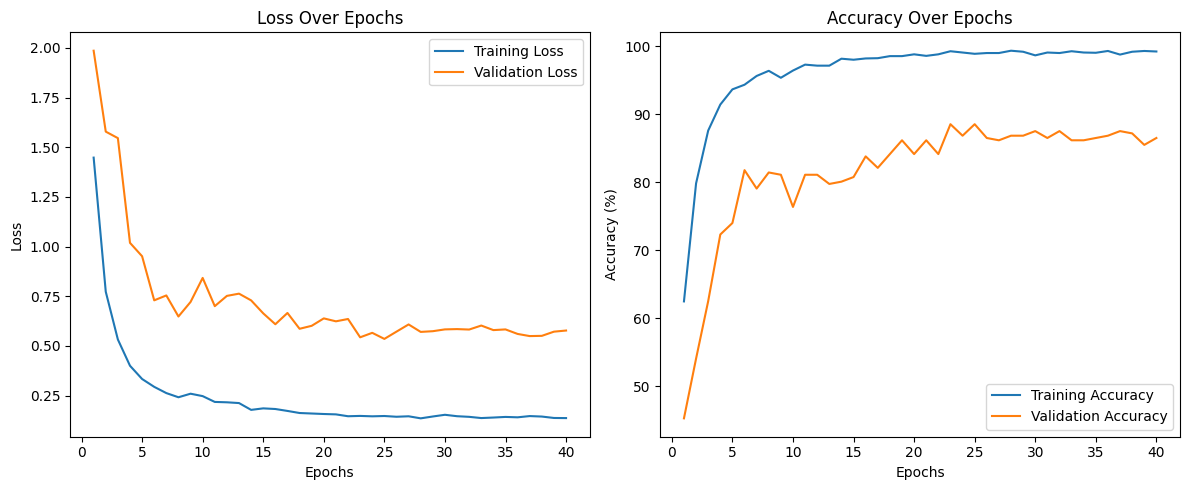

Best accuracy epoch 23
	Validation Loss: 0.5433466136455536, Validation Accuracy: 88.51351351351352


In [ ]:
losses, accuracies, val_losses, val_accuracies, best_accuracy, best_loss, best_epoch = train_loop(resnet_train_loader, resnet_val_loader, model_ft, criterion, optimizer_ft, exp_lr_scheduler)
plot_stats(num_epochs, losses, val_losses, accuracies, val_accuracies)
print(f"Best accuracy epoch {best_epoch+1}\n\tValidation Loss: {best_loss}, Validation Accuracy: {best_accuracy}")

## Transfer learning and fine tuning

After a completely unfrozen fine-tuning approach we decided to test a more solid approach from a theoretical point of view.<br>As seen during the course and throughout the internet (online sources: https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e, https://www.youtube.com/watch?v=qaDe0qQZ5AQ, https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) it is usually very efficient to freeze the feature extractor's parameters in the beginning of the training to let only the classifier learn using the knowledge already acquired by the feature extractor on a larger dataset.<br>At the end of the training it is then suggested to train for a few epochs with a reduced learning rate the whole model.<br>Even in this case we used the hyperparameters used in our network, split unevenly between frozen epochs and unfrozen epochs.

In [ ]:
frozen_epochs = 30 # @param {"type":"integer"}
unfrozen_epochs = 10 # @param {"type":"integer"}

In [ ]:
# Define again the model to restart training
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Freeze parameters of the model
for param in model_ft.parameters():
    param.requires_grad = False

# Extract the input features of the classifier
num_ftrs = model_ft.fc.in_features

# Change the classifier
model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)

# Move the model to GPU
model_ft = model_ft.to(device)

#reinizializing optimizer and scheduler
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=learning_rate, weight_decay = weight_decay)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, gamma=gamma)

Training on 30 epochs with frozen parameters
Epoch [4/30]
 Loss: 1.0549, Accuracy: 78.5985
 Validation Loss: 1.2481, Validation Accuracy: 66.5541
Epoch [8/30]
 Loss: 0.7123, Accuracy: 87.8030
 Validation Loss: 1.0132, Validation Accuracy: 72.2973
Epoch [12/30]
 Loss: 0.6174, Accuracy: 89.1288
 Validation Loss: 0.9183, Validation Accuracy: 76.3514
Epoch [16/30]
 Loss: 0.5772, Accuracy: 89.8106
 Validation Loss: 0.9066, Validation Accuracy: 78.0405
Epoch [20/30]
 Loss: 0.5347, Accuracy: 91.1742
 Validation Loss: 0.8614, Validation Accuracy: 78.0405
Epoch [24/30]
 Loss: 0.5134, Accuracy: 91.6667
 Validation Loss: 0.8646, Validation Accuracy: 77.3649
Epoch [28/30]
 Loss: 0.5180, Accuracy: 91.3258
 Validation Loss: 0.8402, Validation Accuracy: 79.3919


/tmp/ipykernel_30/567881470.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft = torch.load("best-model.pt")





Training on 10 epochs with unfrozen parameters
Epoch [4/10]
 Loss: 0.4928, Accuracy: 91.3636
 Validation Loss: 0.8234, Validation Accuracy: 78.7162
Epoch [8/10]
 Loss: 0.4960, Accuracy: 90.7955
 Validation Loss: 0.8170, Validation Accuracy: 77.0270
Best accuracy epoch 31
	Validation Loss: 0.8395430207252502, Validation Accuracy: 80.06756756756756


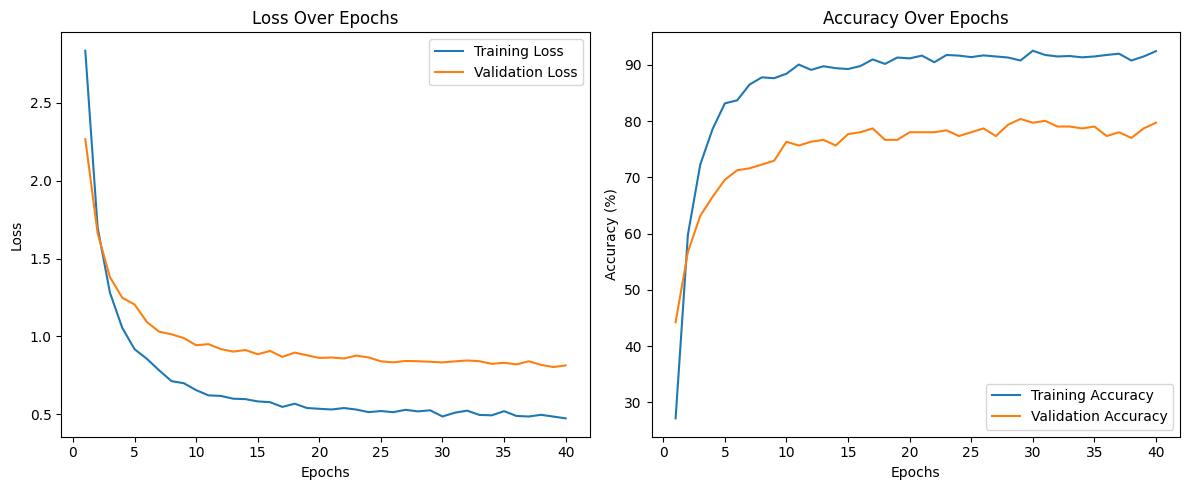

In [ ]:
num_epochs=frozen_epochs
print(f"Training on {frozen_epochs} epochs with frozen parameters")
losses_rn_1, accuracies_rn_1, val_losses_rn_1, val_accuracies_rn_1, best_accuracy_rn, best_loss_rn, best_epoch_rn = train_loop(resnet_train_loader, resnet_val_loader, model_ft, criterion, optimizer_ft, exp_lr_scheduler)

for param in model_ft.parameters():
    param.requires_grad = True

model_ft = torch.load("best-model.pt")

optimizer_ft = optim.AdamW(model_ft.parameters(), lr=learning_rate*0.1, weight_decay = weight_decay)
best_epoch_frozen = best_epoch_rn

num_epochs=unfrozen_epochs
print('\n\n')
print(f"Training on {unfrozen_epochs} epochs with unfrozen parameters")
losses_rn_2, accuracies_rn_2, val_losses_rn_2, val_accuracies_rn_2, best_accuracy_rn, best_loss_rn, best_epoch_rn = train_loop(resnet_train_loader, resnet_val_loader, model_ft, criterion, optimizer_ft, exp_lr_scheduler)

if best_epoch_rn == best_epoch_frozen:
    print(f"Best accuracy epoch {best_epoch_rn+1}\n\tValidation Loss: {best_loss_rn}, Validation Accuracy: {best_accuracy_rn}")
else:
    print(f"Best accuracy epoch {frozen_epochs+best_epoch_rn+1}\n\tValidation Loss: {best_loss_rn}, Validation Accuracy: {best_accuracy_rn}")

plot_stats(frozen_epochs+unfrozen_epochs, losses_rn_1+losses_rn_2, val_losses_rn_1+val_losses_rn_2, accuracies_rn_1+accuracies_rn_2, val_accuracies_rn_1+val_accuracies_rn_2)

We can observe that using transfer learning, despite being a more sound approach, we obtain less satifying results.

## Changing the Hyperparameters

Since our objective is now to tweak the hyperparameters to achieave better results we decided that our starting point should be the best approach between those seen before. For this reason we will mantain the simple fine tuning approach.

In [ ]:
num_classes = resnet_dataset.get_num_classes()
# Create the model with pretrained weights
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Extract the input features of the classifier
num_ftrs = model_ft.fc.in_features

# Change the classifier
model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)

# Move the model to GPU
model_ft = model_ft.to(device)

### Changing Learning Rate and Number of epochs

From the simple fine tuning loss graph we can clearly see an unsteady descent towards the minimum, so our first decision is to reduce the learning rate by a factor of 10.
After this changes it was possible to observe that the great number of epochs was not needed anymore so, to avoid overfitting and to reduce the computation time we halved it.

In [ ]:
learning_rate /= 10
num_epochs = 20

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=learning_rate, weight_decay = weight_decay)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, gamma=gamma)

Epoch [4/20]
 Loss: 0.3432, Accuracy: 95.1515
 Validation Loss: 0.5847, Validation Accuracy: 86.4865
Epoch [8/20]
 Loss: 0.2109, Accuracy: 97.7652
 Validation Loss: 0.4993, Validation Accuracy: 91.5541
Epoch [12/20]
 Loss: 0.1750, Accuracy: 98.4848
 Validation Loss: 0.4582, Validation Accuracy: 89.8649
Epoch [16/20]
 Loss: 0.1679, Accuracy: 98.5227
 Validation Loss: 0.4598, Validation Accuracy: 90.8784
Epoch [20/20]
 Loss: 0.1647, Accuracy: 98.6364
 Validation Loss: 0.4445, Validation Accuracy: 89.1892


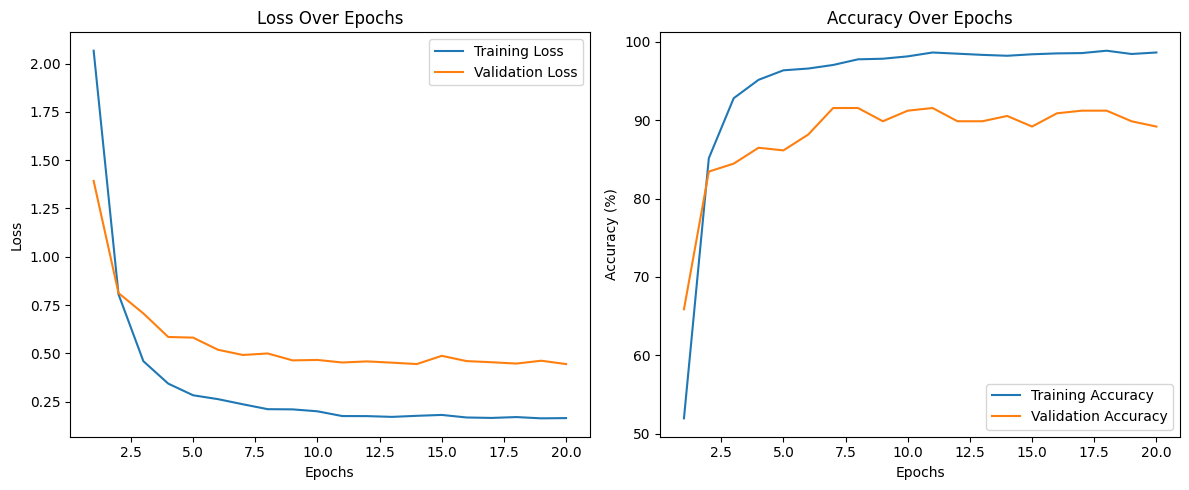

Best accuracy epoch 7
	Validation Loss: 0.4915515065193176, Validation Accuracy: 91.55405405405405


In [ ]:
losses, accuracies, val_losses, val_accuracies, best_accuracy, best_loss, best_epoch = train_loop(resnet_train_loader, resnet_val_loader, model_ft, criterion, optimizer_ft, exp_lr_scheduler)
plot_stats(num_epochs, losses, val_losses, accuracies, val_accuracies)
print(f"Best accuracy epoch {best_epoch+1}\n\tValidation Loss: {best_loss}, Validation Accuracy: {best_accuracy}")

The two main consequences of this choices are:
* the increased accuracy reached by the model
* the smoother descent of the loss function

Which indicates a more effective search for the minimum.